# **Financial Derivatives Pricing & Risk Analysis**

### Project Overview
This project demonstrates a full workflow that mirrors the responsibilities of a quantitative analyst or risk manager:
1.	Collect real market data for a publicly traded stock (Apple Inc., AAPL).
2.	Model the price behavior using historical and conditional volatility (GARCH).
3.	Price derivatives (European call options) using Black-Scholes and calculate sensitivities (Greeks).
4.	Construct a portfolio combining the stock and options.
5.	Measure and simulate portfolio risk using parametric and Monte Carlo Value at Risk (VaR).
6.	Visualize results and interpret findings for practical decision-making.

**Objective**: Show the ability to integrate data analysis, statistical modeling, financial theory, and risk management into a coherent, quantitative workflow.

In [1]:
# Import necessary libraries
import yfinance as yf
import pandas_datareader.data as web
from arch import arch_model

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

#### Step 1: Choose a Stock and Download Market Data

In [2]:
# Choose a stock
ticker = "AAPL" # (Apple Inc.)

In [3]:
# Download last 1 year of daily prices (from Jan 1, 2020 to Jan 1, 2025)
data = yf.download(ticker, start="2020-01-01", end="2025-01-01", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [4]:
data.columns = data.columns.get_level_values(0)
data

Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,72.538521,72.598899,71.292311,71.545897,135480400
2020-01-03,71.833298,72.594063,71.608692,71.765674,146322800
2020-01-06,72.405678,72.444321,70.703012,70.954188,118387200
2020-01-07,72.065147,72.671341,71.845369,72.415337,108872000
2020-01-08,73.224403,73.526295,71.768079,71.768079,132079200
...,...,...,...,...,...
2024-12-24,257.286682,257.296626,254.386957,254.586262,23234700
2024-12-26,258.103729,259.179926,256.718662,257.276679,27237100
2024-12-27,254.685883,257.784897,252.164833,256.917949,42355300


In [5]:
data.isna().sum()

Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

#### Step 2: Calculate Daily Returns

In [6]:
data['Returns'] = data['Close'].pct_change()

#### Step 3: Calculate Volatility

##### 3a: Historical Volatility
It is a standard deviation of returns, showing how "noisy" or "risky" the asset is. 

In [7]:
# Calculate annualized volatility
daily_vol = data['Returns'].std()
annual_vol = daily_vol * np.sqrt(252)  # 252 trading days in a year

print(f"\nAnnualized Volatility: {annual_vol:.4f}")


Annualized Volatility: 0.3168


This shows that Apple's stock fluctuates ~31.7% per year on average

##### 3b: GARCH Volatility Modeling

Real markets exhibit volatility clustering (calm perdios vs. high-stress periods). Hence, we use statistical models to model how volatility changes over time. We compare historical constant volatility with conditional volatility from GARCH.

Notes about ARCH:

* ARCH stands for Autoregressive Conditional Heteroskedasticity
	* *Autoregressive* → depends on past values.
	* *Conditional* → today’s volatility depends on what happened yesterday.
	* *Heteroskedasticity* → variance (volatility) is not constant; it changes.

* This model says, "If yesterday's return was big (up or down), then today's volatility is likely to be high."

* Mathematically, $\sigma_t^2 = \omega + \alpha \cdot \epsilon^2_{t-1}$
    where, 
    - $\sigma_t^2$ = today's variance (volatility squared)
    - $\epsilon^2_{t-1}$ = yesterday's squared return (big return $\rightarrow$ big volatility)
    - $\omega$, $\alpha$ = constants estimated from data (model fitting)
* ARCH(1) means it looks back one day
While this model is useful, this only looks at the last day's return. That can be too simplistic since volatility tends to 'persist' for a while.


Notes about GARCH:
* GARCH stands for Generalized ARCH (Adds a term for past volatility itself)
* Mathematically, $\sigma_t^2 = \omega + \alpha \cdot \epsilon^2_{t-1} + \beta \cdot \sigma^2_{t-1}$
* This model says that today's volatility depends on two factors: 1. how big yesterday's shock was (ARCH part), and 2. how high volatility was yesterday (GARCH part)
* Can smoothly describe how volatility clusters


##### _Intuitive explanation_

Let’s say you’re watching daily stock returns.
* If yesterday had a big move (e.g. +5% or −5%), today the market feels uncertain → volatility goes up.
→ That’s the ARCH(1) effect (reacting to last shock).
* If volatility was already high yesterday, even if today’s move wasn’t huge, the market tends to “stay nervous.”
→ That’s the GARCH(1) effect (volatility persistence).

So, GARCH(1,1) mixes both effects:

“Volatility today = constant base + reaction to yesterday’s surprise + continuation of yesterday’s volatility.”

In [8]:
returns = data['Returns'].dropna() * 100
garch = arch_model(returns, vol='Garch', p=1, q=1)
res = garch.fit(disp='off')
forecast = res.forecast(horizon=1)
sigma_t = np.sqrt(forecast.variance.values[-1,0]) / 100 # Forecasted volatility for next day
sigma_t_annualized = sigma_t * np.sqrt(252)

In [9]:
print("One day volatility")
print("*------------------*")
print(f"Historical: {daily_vol:.4f}")
print(f"GARCH: {sigma_t:.4f}")

print("\n\nAnnualized volatility")
print("*------------------*")
print(f"Historical: {annual_vol:.4f}")
print(f"GARCH: {sigma_t_annualized:.4f}")


One day volatility
*------------------*
Historical: 0.0200
GARCH: 0.0134


Annualized volatility
*------------------*
Historical: 0.3168
GARCH: 0.2131


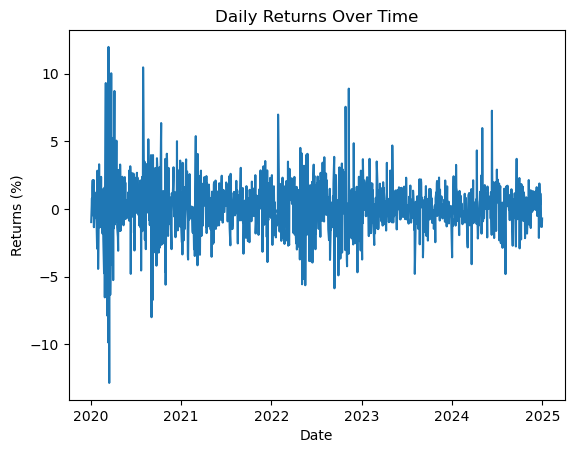

In [10]:
plt.plot(returns.index, returns, label='Daily Returns')
plt.xlabel("Date")
plt.ylabel("Returns (%)")
plt.title("Daily Returns Over Time")
plt.show()

#### Step 4: Black-Scholes Option Pricing

Now we move into derivatives, specifically options. An **option** gives you the right but not the obligation to buy/sell an asset in the future at a fixed price (the strike price, K).

Types
* Call option → right to buy at K
* Put option → right to sell at K

We’ll price a European call option, which can only be exercised at expiry (not before).

The Black-Scholes formula for a European call option is:

$C = S_0 \cdot N(d_1) - K e^{-rT} \cdot N(d_2)$

Where:
* C → Call option price
* S0 → current stock price
* K → strike price
* T → time to expiry/maturity in years
* r → risk-free interest rate
* σ → volatility of the stock
* N() → cumulative normal distribution

Here, 
$ d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)T}{\sigma \sqrt{T}}, \quad d_2 = d_1 - \sigma \sqrt{T}$
* $d_1$:  “moneyness” adjusted for risk and time — how far current price is from strike in standard deviation units.
* $d_2$: same, but excludes half the variance drift.

In [11]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    return call_price

To get risk-free interest rate, we fetch data from Federal Reserve Economic Data (FRED) website, run by U.S. central bank. Some pointers to note:
* `DGS1MO` is the 1-month U.S. Treasury Constant Maturity Rate
* U.S. Treasury - The U.S. government borrows money by selling 'Treasury securities' (like bonds)
* Constant Maturity Rate - standardized interest rate the government publishes every day. It’s like saying, “If we borrowed money for 1 month today, this would be the interest rate.”

**Why we use this?**
This rate is often treated as the risk-free interest rate because lending to the U.S. government for 1 month is considered almost zero risk (they always pay back).
That’s why in finance and investing, people use `DGS1MO` (or other Treasury rates like 3-month, 1-year, etc.) as a baseline to compare other investments.

Hence, if a stock gives you 7% return per year, and the risk-free rate is 5%, you can say that you earned extra reward of 2% for taking risk.

Note: One could also use `DGS3MO`, `DGS6MO`, `DGS1`, etc. but here, we shall assume that the option expiry is 30 days and therefore use `DGS1MO`.

In [12]:
rf = web.DataReader('DGS1MO', 'fred', '2024-01-01', '2025-01-01')  # 1-month Treasury rate
rf

,DGS1MO
DATE,
2024-01-01,NaN
2024-01-02,5.55
2024-01-03,5.54
2024-01-04,5.56
2024-01-05,5.54
...,...
2024-12-26,4.45
2024-12-27,4.44
2024-12-30,4.43


In [13]:
rf_ffill = rf.fillna(method='ffill')  # forward fill missing values (to account from weekends/holidays)
r = rf_ffill.iloc[-1].values[0] / 100  # latest rate as decimal

In [14]:
# For example, taking the last closing price as S0
days_to_expiry = 30  # days until option expiry
K = 170  # strike price

S0 = data['Close'].iloc[-1]  # latest price
T = days_to_expiry/365  # 30 days to expiry
sigma = sigma_t_annualized  # using GARCH forecasted volatility

call_price = black_scholes_call(S0, K, T, r, sigma)
print("European Call Option Price:", call_price)

European Call Option Price: 80.14786386392103


This means that a 1-month call option with strike 170 costs $80.23.

**How to use this information?**
1.	Compare to market price:
    * If market call price > Black-Scholes price → option may be “expensive”
    * If market call price < Black-Scholes price → option may be “cheap”

2.	Estimate risk-adjusted hedging:
    * Use it to determine how many shares to buy/sell to hedge an option (delta-hedging).

3.	Feed into trading strategies:
    * You can combine Black-Scholes price with volatility forecast to make trading decisions.

#### Step 5: The Greeks - Sensitivities

Greeks are derivatives of the option price with respect to key inputs.

Think of Greeks as risk measures:
1.	Delta (Δ) – How much the option price changes if the stock price moves by $1.
	* Measures sensitivity to Stock Price (S)
	* Call option: 0 → 1
	* Put option: -1 → 0
	* Intuition: If Δ = 0.6, a $1 increase in stock → $0.60 increase in call price.
2.	Gamma (Γ) – How much delta changes if the stock price moves by $1.
	* Measures curvature of the option price.
	* Measures sensitivity to Delta $\Delta$
	* High gamma → option price reacts sharply to stock moves.
3.	Theta (Θ) – How much the option price decreases per day due to time decay.
	* Measures sensitivity to Time
	* Options lose value as expiry approaches.
4.	Vega (ν) – How much the option price changes if volatility changes by 1%.
	* Measures sensitivity to Volatility ($\sigma$)
	* Higher volatility → more expensive options.
5.	Rho (ρ) – How much the option price changes if risk-free interest rate $r$ changes by 1%.
	* Measures sensitivity to Interest Rate ($r$)

For European call options, the formulas are:

$\Delta = N(d_1)$

$\Gamma = \frac{N’(d_1)}{S \sigma \sqrt{T}}$

$\Theta = -\frac{S N’(d_1) \sigma}{2\sqrt{T}} - r K e^{-rT} N(d_2)$

Vega = $S \sqrt{T} N’(d_1)$

Rho = $K T e^{-rT} N(d_2)$

Where $N’(d1)$ is the standard normal PDF.

In [15]:
def greeks_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
             - r * K * np.exp(-r*T) * norm.cdf(d2)) / 365  # per day
    vega = S * np.sqrt(T) * norm.pdf(d1) / 100  # per 1% change
    rho = K * T * np.exp(-r*T) * norm.cdf(d2) / 100  # per 1% change
    
    return delta, gamma, theta, vega, rho

delta, gamma, theta, vega, rho = greeks_call(S0, K, T, r, sigma)
print(f"Delta: {delta:.4f}, Gamma: {gamma:.4f}, Theta: {theta:.4f}, Vega: {vega:.4f}, Rho: {rho:.4f}")

Delta: 1.0000, Gamma: 0.0000, Theta: -0.0204, Vega: 0.0000, Rho: 0.1392


* Delta = 1.0 → the option moves almost 1-for-1 with the stock (deep in the money).
* Gamma ≈ 0 → small curvature, consistent with deep ITM option.
* Theta negative → loses value each day as time passes.
* Vega ≈ 0 → volatility doesn’t matter much for deep ITM options.
* Rho positive → higher rates slightly increase the option value.

#### Step 6: Portfolio Setup

We setup up a portfolio combining shares and call option.

In [16]:
shares = 100
option_units = 1  # 1 call option contract = 100 shares

stock_price = S0
option_price = call_price

portfolio_value = shares * stock_price + option_units * option_price
print(f"Portfolio Value: ${portfolio_value:.2f}")

Portfolio Value: $25033.57


#### Step 7: Risk Measurement (VaR)

Tells "How much can I lose in a day, with 95% confidence?"

Think of VaR as a “worst-case loss” indicator:
* Example: “Our 1-day 5% VaR is $1,000.”
* This means there’s a 5% chance that the portfolio will lose more than $1,000 in one day.

There are three main methods to calculate VaR:
1.	Historical Simulation – Use past returns of assets.
2.	Variance-Covariance (Parametric) – Assume returns are normally distributed.
3.	Monte Carlo Simulation – Simulate thousands of possible future outcomes.

In [17]:
data['Portfolio_Returns'] = shares * data['Returns'] + option_units * delta * data['Returns']

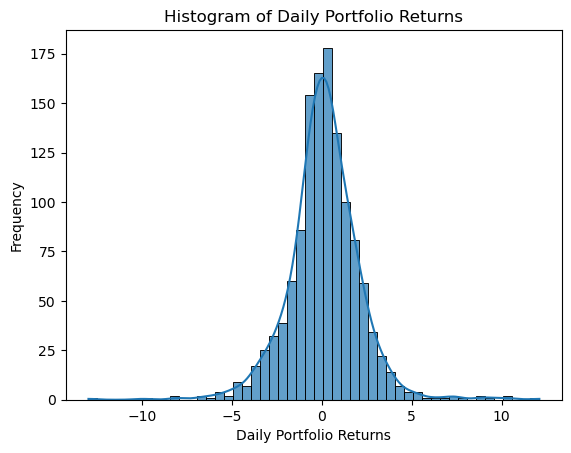

In [18]:
sns.histplot(data['Portfolio_Returns'].dropna(), bins=50, alpha=0.7, kde=True)
plt.xlabel("Daily Portfolio Returns")
plt.ylabel("Frequency")
plt.title("Histogram of Daily Portfolio Returns")
plt.show()

Note that this is a linear approximation, but it works well enough for small moves. We also see a bell-shaped curve, signifying that we can use parametric VaR to approximate risk

##### 7a: 1-Day VaR (Parametric)

Assuming normal distribution of returns:

$\text{VaR} = z_\alpha \cdot \sigma_p \cdot \text{Portfolio Value}$
* $z_\alpha$ = critical value from standard normal (e.g., 1.65 for 5%, in other words z-score for 5th percentile)
* $\sigma_p$ = standard deviation of portfolio returns

In [19]:
confidence_level = 0.05
z = norm.ppf(confidence_level)

# Portfolio standard deviation
sigma_p = data['Portfolio_Returns'].std()

VaR_1day = -z * sigma_p * portfolio_value
print(f"1-Day 5% VaR: ${VaR_1day:.2f}")

1-Day 5% VaR: $82992.25


Interpretation: There’s a 5% chance your portfolio could lose more than this amount tomorrow.

##### 7b: Monte Carlo Simulation for VaR

Idea:
We simulate thousands of possible future stock prices, recalculate the option price using Black-Scholes, then compute the portfolio value for each simulation. Finally, we use the distribution of portfolio changes to estimate VaR.

##### Simulate Future Stock Prices

We assume stock returns are normally distributed, using historical mean and volatility:

$S_{t+1} = S_t \cdot e^{( \mu - 0.5 \sigma^2 ) \Delta t + \sigma \sqrt{\Delta t} \cdot Z}$

Where:
* $Z \sim N(0,1)$
* $\mu$ = average daily return
* $\sigma$ = daily volatility
* $\Delta t$ = 1 day

In [20]:
num_simulations = 100_000
mu = data['Returns'].mean()
sigma_daily = sigma_t
S_t = S0

In [21]:
# Simulate future stock prices
np.random.seed(42)
Z = np.random.normal(0, 1, num_simulations)
S_future = S_t * np.exp((mu - 0.5 * sigma_daily**2) + sigma_daily * Z)

##### Recalculate Option Prices for Each Simulation

We recalculate European call option price for 1-day forward using Black-Scholes.

In [22]:
T_1day = 1/365  # 1 day to expiry
option_prices_future = [black_scholes_call(S, K, T_1day, r, sigma) for S in S_future]
option_prices_future = np.array(option_prices_future)

##### Calculate Portfolio Value Changes

In [23]:
portfolio_future = shares * S_future + option_units * option_prices_future
portfolio_change = portfolio_future - portfolio_value

##### Estimate 1-Day Monte Carlo VaR

Take the 5th percentile of simulated losses:

In [24]:
VaR_mc = -np.percentile(portfolio_change, 5)
print(f"1-Day 5% Monte Carlo VaR: ${VaR_mc:.2f}")

1-Day 5% Monte Carlo VaR: $523.58


##### Visualize the distribution

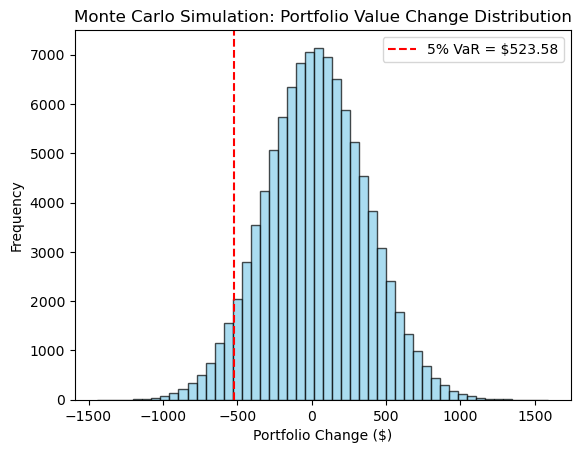

In [25]:
plt.hist(portfolio_change, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(-VaR_mc, color='red', linestyle='--', label=f'5% VaR = ${VaR_mc:.2f}')
plt.title("Monte Carlo Simulation: Portfolio Value Change Distribution")
plt.xlabel("Portfolio Change ($)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Step 8: Conclusions

Key Takeaways:
* GARCH models provide a more realistic volatility estimate than historical σ.
* Black-Scholes allows pricing and hedging of European options; Greeks quantify risk exposures.
* Portfolio VaR estimates demonstrate the impact of derivatives on risk.
* Monte Carlo simulation captures nonlinear portfolio effects that parametric VaR may miss.

Overall:
This project demonstrates the ability to go from market data → quantitative modeling → derivatives pricing → risk measurement — the core workflow of a financial analyst or quant.

#### Step 9: Future Work & Extensions

1.	Multi-Asset Portfolio:
    * Include correlated stocks to model portfolio diversification effects
2.	Delta-Hedging Simulation:
    * Track P&L while rebalancing to maintain delta-neutral portfolio
3.	Expected Shortfall (CVaR):
    * Complement VaR with average loss beyond the threshold
4.	Alternative Pricing Models:
    * Binomial trees for American options, or Monte Carlo for exotic options
5. Implied Volatility Analysis:
	* Compare Black-Scholes implied vol with market option prices
	* Visualize volatility smile or surface


✅ What we've achieved:
1.	Simulated thousands of possible future stock prices.
2.	Repriced the option for each scenario.
3.	Calculated the portfolio change distribution.
4.	Computed Monte Carlo 1-day VaR.
5.	Visualized portfolio risk with a histogram.

This completes a full workflow from option pricing to risk management.